In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/SAiDL-2024/MoE/dataset.py /content/dataset.py
!cp /content/drive/MyDrive/SAiDL-2024/MoE/trainer.py /content/trainer.py
!cp /content/drive/MyDrive/SAiDL-2024/MoE/tokenizer.py /content/tokenizer.py
!cp /content/drive/MyDrive/SAiDL-2024/MoE/moe.py /content/moe.py
!cp /content/drive/MyDrive/SAiDL-2024/MoE/models.py /content/models.py

Mounted at /content/drive


**Table of contents**<a id='toc0_'></a>    
- [Utils](#toc1_)    
- [Baseline](#toc2_)    
  - [Without MoE with Single Linear Layer in Between](#toc2_1_)    
  - [With MoE](#toc2_2_)    
- [With Top-K Mask](#toc3_)    
- [Noisy Top-k Gating](#toc4_)    
- [Importance with Top-k Mask](#toc5_)    
- [Load with Noisy Top-k Gating](#toc6_)    
- [Plots](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [2]:
import torch
import torch.nn as nn
import pickle
from tokenizer import Tokenizer
from dataset import SquadDataset
from models import SquadBaseLSTM,SquadLSTM_MoE
from trainer import SquadTrainer
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
with open('/content/drive/MyDrive/SAiDL-2024/MoE/squad-assets/idx2token.pkl', 'rb') as file:
    idx2token = pickle.load(file)
with open('/content/drive/MyDrive/SAiDL-2024/MoE/squad-assets/token2idx.pkl', 'rb') as file:
    token2idx = pickle.load(file)
train_df = pd.read_csv('/content/drive/MyDrive/SAiDL-2024/MoE/squad-assets/train_data.csv')
val_df = pd.read_csv('/content/drive/MyDrive/SAiDL-2024/MoE/squad-assets/dev_data.csv')

squad_tokenizer = Tokenizer(idx2token,token2idx,maxlen=256)
squad_dataset_train = SquadDataset(train_df,squad_tokenizer)
squad_dataset_val = SquadDataset(val_df,squad_tokenizer)

In [4]:
# Useful Constants
EPOCHS = 5
EMBEDDING_DIM = 50
VOCAB_SIZE = len(idx2token)
NUM_EXPERTS = 8
LSTM_HIDDEN_DIM = 128
EXPERT_HIDDEN_DIM = 128
BATCH_SIZE = 32
MANUAL_SEED = 1337
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TOP_K = 2
W_IMPORTANCE = 0.1
W_LOAD = 0.1
MODEL_SAVE_PATH = "/content/drive/MyDrive/SAiDL-2024/MoE/models/squad"

In [5]:
train_dataloader = DataLoader(squad_dataset_train,BATCH_SIZE,True)
val_dataloader = DataLoader(squad_dataset_val,BATCH_SIZE)
embedding_state_dict = torch.load('/content/drive/MyDrive/SAiDL-2024/MoE/squad-assets/squad.glove.6B.50d.pt',map_location=DEVICE)

# <a id='toc1_'></a>[Utils](#toc0_)

In [6]:
def get_router_outputs(val_dataloader: DataLoader,
                       model: SquadLSTM_MoE):
    model.eval()
    # Save activations for all val inputs.
    router_activations = []
    # Create hook to only fetch router outputs
    def hook(module,input,output):
      router_activations.append(output[0].cpu())
    router = model.moe.router
    handle = router.register_forward_hook(hook)

    # Loop over dataloader.
    for contexts,questions,_,_ in val_dataloader:
      contexts,questions = contexts.to(DEVICE),questions.to(DEVICE)
      with torch.no_grad():
        model(contexts,questions)
    handle.remove()

    # Stack router outputs
    router_activations = torch.concat(router_activations,dim=0)
    router_activations = router_activations.view(-1,router_activations.size(-1))

    # Get max indices
    router_activations = (router_activations != 0).int()

    return router_activations


def plot_expert_distribution(val_dataloader: DataLoader,
                             model: SquadLSTM_MoE):
    # Get router outputs
    router_outputs = get_router_outputs(val_dataloader,model)
    # Get distribution of each expert.
    distribution = router_outputs.sum(dim=0)

    xlabel='Experts'
    ylabel='Tokens Received'
    num_experts = len(distribution)
    plt.figure(figsize=(7, 5))
    plt.bar(np.arange(num_experts), distribution.numpy(), color='steelblue', alpha=0.7, edgecolor='black', width=1.0)

    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(np.arange(num_experts), [f"{i}" for i in range(num_experts)])
    plt.grid(False)

    plt.tight_layout()
    plt.show()



def save(model: nn.Module,
         trainer: SquadTrainer,
         path: str):
    """Saves the model weights and its training history."""
    torch.save({
      'state_dict': model.state_dict(),
      'history': trainer.history
    },path)

# <a id='toc2_'></a>[Baseline](#toc0_)

## <a id='toc2_1_'></a>[Without MoE with Single Linear Layer in Between](#toc0_)

In [34]:
torch.manual_seed(MANUAL_SEED)
lstm_baseline = SquadBaseLSTM(VOCAB_SIZE,
                               EMBEDDING_DIM,
                               LSTM_HIDDEN_DIM,
                               EXPERT_HIDDEN_DIM,
                               embedding_state_dict)
lstm_baseline_optim = Adam(filter(lambda p: p.requires_grad, lstm_baseline.parameters()))

In [35]:
lstm_baseline_trainer = SquadTrainer(lstm_baseline,
                                     train_dataloader,
                                     val_dataloader,
                                     lstm_baseline_optim,
                                     DEVICE)

In [9]:
lstm_baseline_trainer.train(EPOCHS)

Epoch 1/5


100%|██████████| 1028/1028 [00:31<00:00, 32.23batch/s, loss=9.24]


Epoch 1/5
Train loss: 9.0767 | Train accuracy: 0.0494
Val loss: 8.9861 | Val accuracy: 0.1051
 
Epoch 2/5


100%|██████████| 1028/1028 [00:31<00:00, 33.12batch/s, loss=9]


Epoch 2/5
Train loss: 8.7329 | Train accuracy: 0.0574
Val loss: 8.8565 | Val accuracy: 0.1113
 
Epoch 3/5


100%|██████████| 1028/1028 [00:30<00:00, 33.56batch/s, loss=9.58]


Epoch 3/5
Train loss: 8.6040 | Train accuracy: 0.0615
Val loss: 8.7545 | Val accuracy: 0.1112
 
Epoch 4/5


100%|██████████| 1028/1028 [00:30<00:00, 33.72batch/s, loss=9.72]


Epoch 4/5
Train loss: 8.5127 | Train accuracy: 0.0640
Val loss: 8.7025 | Val accuracy: 0.1168
 
Epoch 5/5


100%|██████████| 1028/1028 [00:30<00:00, 34.10batch/s, loss=9.39]

Epoch 5/5
Train loss: 8.5620 | Train accuracy: 0.0631
Val loss: 8.7698 | Val accuracy: 0.1146
 


In [10]:
print(f"Final negative validation log-likelihood: {lstm_baseline_trainer.history['val_loss'][-1]}")
print(f"Final negative validation accuracy: {lstm_baseline_trainer.history['val_acc'][-1]}")

Final negative validation log-likelihood: 8.769800373088525
Final negative validation accuracy: 0.11458903692887996


In [15]:
save(lstm_baseline,lstm_baseline_trainer,f'{MODEL_SAVE_PATH}/lstm_baseline.pt')

## <a id='toc2_2_'></a>[With MoE](#toc0_)

In [17]:
torch.manual_seed(MANUAL_SEED)
moe_baseline = SquadLSTM_MoE(VOCAB_SIZE,
                             EMBEDDING_DIM,
                             LSTM_HIDDEN_DIM,
                             EXPERT_HIDDEN_DIM,
                             embedding_state_dict,
                             'top_k',
                             NUM_EXPERTS,
                             TOP_K)
moe_baseline_optim = Adam(filter(lambda p: p.requires_grad, moe_baseline.parameters()))

In [18]:
moe_baseline_trainer = SquadTrainer(moe_baseline,
                                     train_dataloader,
                                     val_dataloader,
                                     moe_baseline_optim,
                                     DEVICE)

In [18]:
moe_baseline_trainer.train(EPOCHS)

Epoch 1/5


100%|██████████| 1028/1028 [00:40<00:00, 25.10batch/s, loss=9.76]


Epoch 1/5
Train loss: 9.0773 | Train accuracy: 0.0490
Val loss: 8.8241 | Val accuracy: 0.1042
 
Epoch 2/5


100%|██████████| 1028/1028 [00:41<00:00, 24.72batch/s, loss=9.74]


Epoch 2/5
Train loss: 8.6570 | Train accuracy: 0.0583
Val loss: 8.7654 | Val accuracy: 0.1084
 
Epoch 3/5


100%|██████████| 1028/1028 [00:41<00:00, 24.98batch/s, loss=10]


Epoch 3/5
Train loss: 8.5620 | Train accuracy: 0.0622
Val loss: 8.7208 | Val accuracy: 0.1137
 
Epoch 4/5


100%|██████████| 1028/1028 [00:42<00:00, 24.46batch/s, loss=9.73]


Epoch 4/5
Train loss: 8.4914 | Train accuracy: 0.0648
Val loss: 8.7065 | Val accuracy: 0.1158
 
Epoch 5/5


100%|██████████| 1028/1028 [00:40<00:00, 25.50batch/s, loss=10]

Epoch 5/5
Train loss: 8.4311 | Train accuracy: 0.0672
Val loss: 8.7104 | Val accuracy: 0.1162
 


In [20]:
save(moe_baseline,moe_baseline_trainer,f'{MODEL_SAVE_PATH}/moe_baseline.pt')

In [21]:
print(f"Final negative validation log-likelihood: {moe_baseline_trainer.history['val_loss'][-1]}")
print(f"Final negative validation accuracy: {moe_baseline_trainer.history['val_acc'][-1]}")

Final negative validation log-likelihood: 8.71036779694984
Final negative validation accuracy: 0.11623167244631015


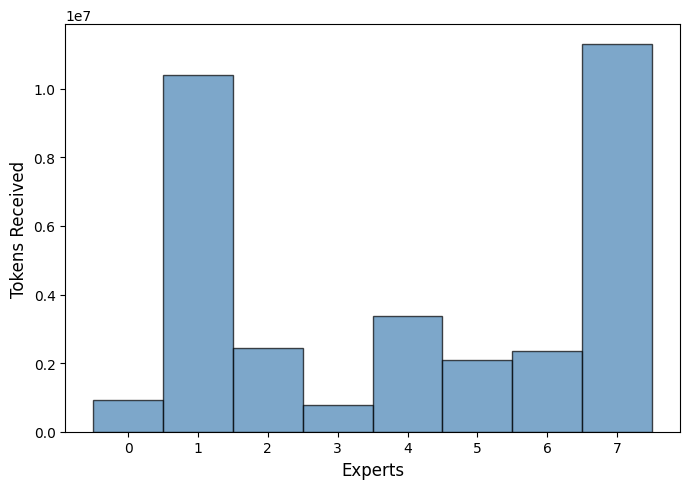

In [22]:
plot_expert_distribution(val_dataloader,moe_baseline)

# <a id='toc3_'></a>[With Top-K Mask](#toc0_)

In [20]:
torch.manual_seed(MANUAL_SEED)
moe_topk_mask = SquadLSTM_MoE(VOCAB_SIZE,
                             EMBEDDING_DIM,
                             LSTM_HIDDEN_DIM,
                             EXPERT_HIDDEN_DIM,
                             embedding_state_dict,
                             'top_k_mask',
                             NUM_EXPERTS,
                             TOP_K)
moe_topk_mask_optim = Adam(filter(lambda p: p.requires_grad, moe_topk_mask.parameters()))

In [21]:
moe_topk_mask_trainer = SquadTrainer(moe_topk_mask,
                                     train_dataloader,
                                     val_dataloader,
                                     moe_topk_mask_optim,
                                     DEVICE)

In [25]:
moe_topk_mask_trainer.train(EPOCHS)

Epoch 1/5


100%|██████████| 1028/1028 [00:40<00:00, 25.38batch/s, loss=9.74]


Epoch 1/5
Train loss: 9.0536 | Train accuracy: 0.0504
Val loss: 8.9257 | Val accuracy: 0.1054
 
Epoch 2/5


100%|██████████| 1028/1028 [00:39<00:00, 26.27batch/s, loss=9.7]


Epoch 2/5
Train loss: 8.7820 | Train accuracy: 0.0570
Val loss: 8.8520 | Val accuracy: 0.1066
 
Epoch 3/5


100%|██████████| 1028/1028 [00:38<00:00, 26.42batch/s, loss=9.59]


Epoch 3/5
Train loss: 8.6078 | Train accuracy: 0.0604
Val loss: 8.7470 | Val accuracy: 0.1113
 
Epoch 4/5


100%|██████████| 1028/1028 [00:40<00:00, 25.50batch/s, loss=9.14]


Epoch 4/5
Train loss: 8.5271 | Train accuracy: 0.0631
Val loss: 8.7307 | Val accuracy: 0.1124
 
Epoch 5/5


100%|██████████| 1028/1028 [00:37<00:00, 27.36batch/s, loss=9.38]

Epoch 5/5
Train loss: 8.5481 | Train accuracy: 0.0646
Val loss: 8.7655 | Val accuracy: 0.1147
 


In [26]:
save(moe_topk_mask,moe_topk_mask_trainer,f'{MODEL_SAVE_PATH}/moe_top_k_mask.pt')

In [27]:
print(f"Final negative validation log-likelihood: {moe_topk_mask_trainer.history['val_loss'][-1]}")
print(f"Final negative validation accuracy: {moe_topk_mask_trainer.history['val_acc'][-1]}")

Final negative validation log-likelihood: 8.765514737901057
Final negative validation accuracy: 0.1147411328101235


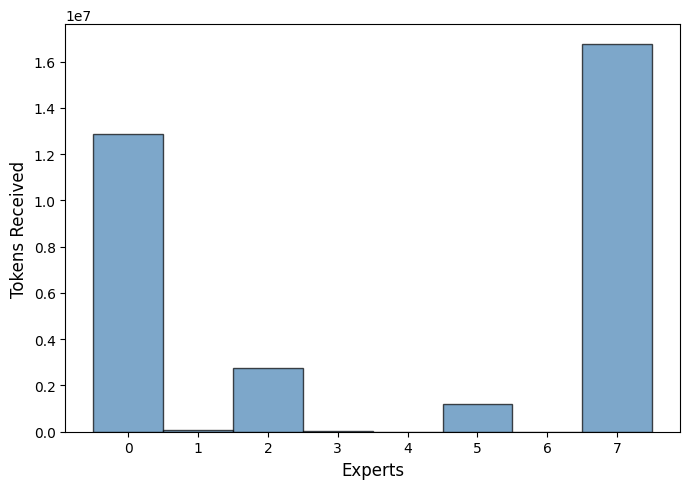

In [28]:
plot_expert_distribution(val_dataloader,moe_topk_mask)

# <a id='toc4_'></a>[Noisy Top-k Gating](#toc0_)

In [23]:
torch.manual_seed(MANUAL_SEED)
moe_noisy = SquadLSTM_MoE(VOCAB_SIZE,
                             EMBEDDING_DIM,
                             LSTM_HIDDEN_DIM,
                             EXPERT_HIDDEN_DIM,
                             embedding_state_dict,
                             'noisy_top_k',
                             NUM_EXPERTS,
                             TOP_K)
moe_noisy_optim = Adam(filter(lambda p: p.requires_grad, moe_noisy.parameters()))

In [24]:
moe_noisy_trainer = SquadTrainer(moe_noisy,
                                 train_dataloader,
                                 val_dataloader,
                                 moe_noisy_optim,
                                 DEVICE)

In [31]:
moe_noisy_trainer.train(EPOCHS)

Epoch 1/5


100%|██████████| 1028/1028 [00:36<00:00, 28.06batch/s, loss=9.76]


Epoch 1/5
Train loss: 9.0596 | Train accuracy: 0.0495
Val loss: 8.9323 | Val accuracy: 0.1028
 
Epoch 2/5


100%|██████████| 1028/1028 [00:37<00:00, 27.62batch/s, loss=9.86]


Epoch 2/5
Train loss: 8.6843 | Train accuracy: 0.0594
Val loss: 8.7919 | Val accuracy: 0.1105
 
Epoch 3/5


100%|██████████| 1028/1028 [00:38<00:00, 26.97batch/s, loss=9.84]


Epoch 3/5
Train loss: 8.5929 | Train accuracy: 0.0622
Val loss: 8.7381 | Val accuracy: 0.1140
 
Epoch 4/5


100%|██████████| 1028/1028 [00:40<00:00, 25.51batch/s, loss=9.69]


Epoch 4/5
Train loss: 8.5228 | Train accuracy: 0.0644
Val loss: 8.7436 | Val accuracy: 0.1177
 
Epoch 5/5


100%|██████████| 1028/1028 [00:38<00:00, 26.58batch/s, loss=9.54]

Epoch 5/5
Train loss: 8.4579 | Train accuracy: 0.0662
Val loss: 8.7186 | Val accuracy: 0.1140
 


In [32]:
save(moe_noisy,moe_noisy_trainer,f'{MODEL_SAVE_PATH}/moe_noisy.pt')

In [33]:
print(f"Final negative validation log-likelihood: {moe_noisy_trainer.history['val_loss'][-1]}")
print(f"Final negative validation accuracy: {moe_noisy_trainer.history['val_acc'][-1]}")

Final negative validation log-likelihood: 8.718640020385326
Final negative validation accuracy: 0.11398065340390583


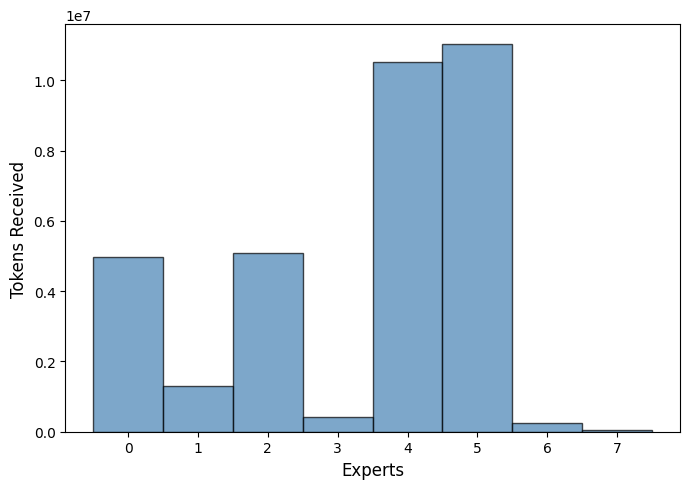

In [34]:
plot_expert_distribution(val_dataloader,moe_noisy)

# <a id='toc5_'></a>[Importance with Top-k Mask](#toc0_)

In [31]:
torch.manual_seed(MANUAL_SEED)
moe_importance_mask = SquadLSTM_MoE(VOCAB_SIZE,
                             EMBEDDING_DIM,
                             LSTM_HIDDEN_DIM,
                             EXPERT_HIDDEN_DIM,
                             embedding_state_dict,
                             'top_k_mask',
                             NUM_EXPERTS,
                             TOP_K)
moe_importance_mask_optim = Adam(filter(lambda p: p.requires_grad, moe_importance_mask.parameters()))

In [32]:
moe_importance_mask_trainer = SquadTrainer(moe_importance_mask,
                                     train_dataloader,
                                     val_dataloader,
                                     moe_importance_mask_optim,
                                     DEVICE,
                                     importance_cv_squared = True,
                                     w_importance=W_IMPORTANCE)

In [37]:
moe_importance_mask_trainer.train(EPOCHS)

Epoch 1/5


100%|██████████| 1028/1028 [00:39<00:00, 26.23batch/s, loss=9.32]


Epoch 1/5
Train loss: 9.1957 | Train accuracy: 0.0501
Val loss: 8.8435 | Val accuracy: 0.1036
 
Epoch 2/5


100%|██████████| 1028/1028 [00:38<00:00, 26.87batch/s, loss=9.57]


Epoch 2/5
Train loss: 8.8517 | Train accuracy: 0.0580
Val loss: 8.7854 | Val accuracy: 0.1093
 
Epoch 3/5


100%|██████████| 1028/1028 [00:39<00:00, 25.86batch/s, loss=9.31]


Epoch 3/5
Train loss: 8.7515 | Train accuracy: 0.0601
Val loss: 8.7451 | Val accuracy: 0.1101
 
Epoch 4/5


100%|██████████| 1028/1028 [00:38<00:00, 26.41batch/s, loss=9.38]


Epoch 4/5
Train loss: 8.7064 | Train accuracy: 0.0632
Val loss: 8.7266 | Val accuracy: 0.1093
 
Epoch 5/5


100%|██████████| 1028/1028 [00:39<00:00, 26.32batch/s, loss=9.63]

Epoch 5/5
Train loss: 8.6255 | Train accuracy: 0.0647
Val loss: 8.7939 | Val accuracy: 0.1146
 


In [38]:
save(moe_importance_mask,moe_importance_mask_trainer,f'{MODEL_SAVE_PATH}/moe_importance_mask.pt')

In [39]:
print(f"Final negative validation log-likelihood: {moe_importance_mask_trainer.history['val_loss'][-1]}")
print(f"Final negative validation accuracy: {moe_importance_mask_trainer.history['val_acc'][-1]}")

Final negative validation log-likelihood: 8.793926964937945
Final negative validation accuracy: 0.11461945610512868


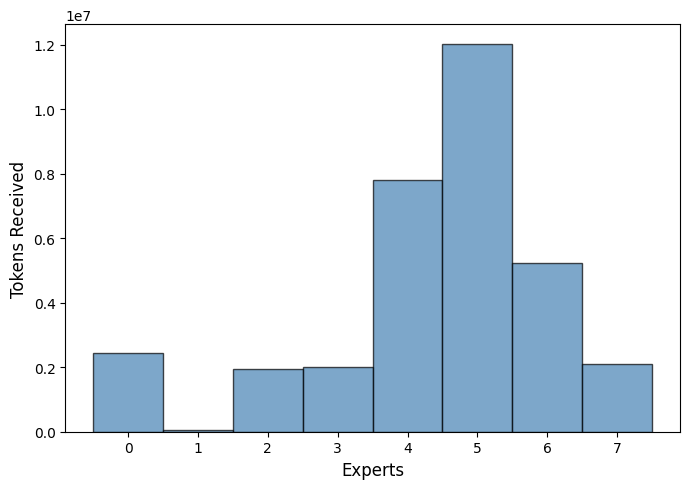

In [40]:
plot_expert_distribution(val_dataloader,moe_importance_mask)

# <a id='toc6_'></a>[Load with Noisy Top-k Gating](#toc0_)

In [7]:
torch.manual_seed(MANUAL_SEED)
moe_noisy_load = SquadLSTM_MoE(VOCAB_SIZE,
                             EMBEDDING_DIM,
                             LSTM_HIDDEN_DIM,
                             EXPERT_HIDDEN_DIM,
                             embedding_state_dict,
                             'noisy_top_k',
                             NUM_EXPERTS,
                             TOP_K)
moe_noisy_load_optim = Adam(filter(lambda p: p.requires_grad, moe_noisy_load.parameters()))

In [8]:
moe_noisy_load_trainer = SquadTrainer(moe_noisy_load,
                                     train_dataloader,
                                     val_dataloader,
                                     moe_noisy_load_optim,
                                     DEVICE,
                                     load_cv_squared = True,
                                     w_load=W_LOAD)

In [9]:
moe_noisy_load_trainer.train(EPOCHS)

Epoch 1/5


100%|██████████| 1028/1028 [00:38<00:00, 26.40batch/s, loss=9.28]


Epoch 1/5
Train loss: 9.0382 | Train accuracy: 0.0490
Val loss: 8.8511 | Val accuracy: 0.1054
 
Epoch 2/5


100%|██████████| 1028/1028 [00:38<00:00, 26.74batch/s, loss=9.01]


Epoch 2/5
Train loss: 8.6707 | Train accuracy: 0.0582
Val loss: 8.7549 | Val accuracy: 0.1120
 
Epoch 3/5


100%|██████████| 1028/1028 [00:38<00:00, 26.64batch/s, loss=9.61]


Epoch 3/5
Train loss: 8.6087 | Train accuracy: 0.0612
Val loss: 8.7616 | Val accuracy: 0.1146
 
Epoch 4/5


100%|██████████| 1028/1028 [00:37<00:00, 27.46batch/s, loss=9.82]


Epoch 4/5
Train loss: 8.5238 | Train accuracy: 0.0631
Val loss: 8.7627 | Val accuracy: 0.1153
 
Epoch 5/5


100%|██████████| 1028/1028 [00:37<00:00, 27.06batch/s, loss=9.69]

Epoch 5/5
Train loss: 8.4562 | Train accuracy: 0.0659
Val loss: 8.7098 | Val accuracy: 0.1176
 


In [10]:
save(moe_noisy_load,moe_noisy_load_trainer,f'{MODEL_SAVE_PATH}/moe_noisy_load_importance.pt')

In [11]:
print(f"Final negative validation log-likelihood: {moe_noisy_load_trainer.history['val_loss'][-1]}")
print(f"Final negative validation accuracy: {moe_noisy_load_trainer.history['val_acc'][-1]}")

Final negative validation log-likelihood: 8.709823411262454
Final negative validation accuracy: 0.11760053537750198


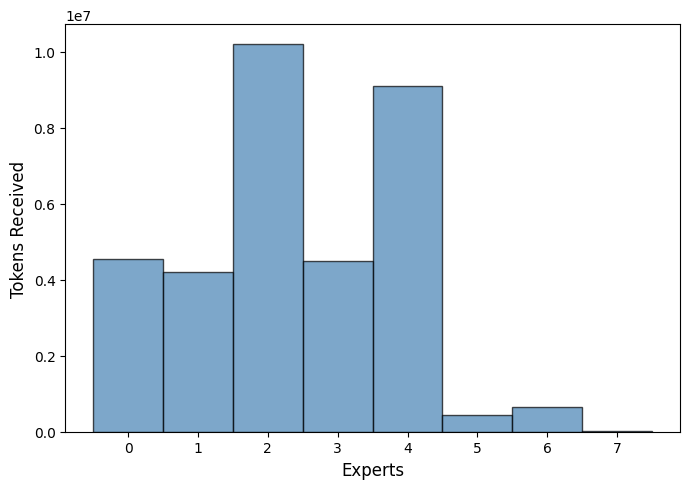

In [12]:
plot_expert_distribution(val_dataloader,moe_noisy_load)

# <a id='toc7_'></a>[Plots](#toc0_)

In [45]:
trainers = {
    'LSTM Baseline':lstm_baseline_trainer,
    'MoE Naive':moe_baseline_trainer,
    'MoE Mask':moe_topk_mask_trainer,
    'MoE Noisy TopK':moe_noisy_trainer,
    'MoE Importance':moe_importance_mask_trainer,
    'MoE Load':moe_noisy_load_trainer,
}

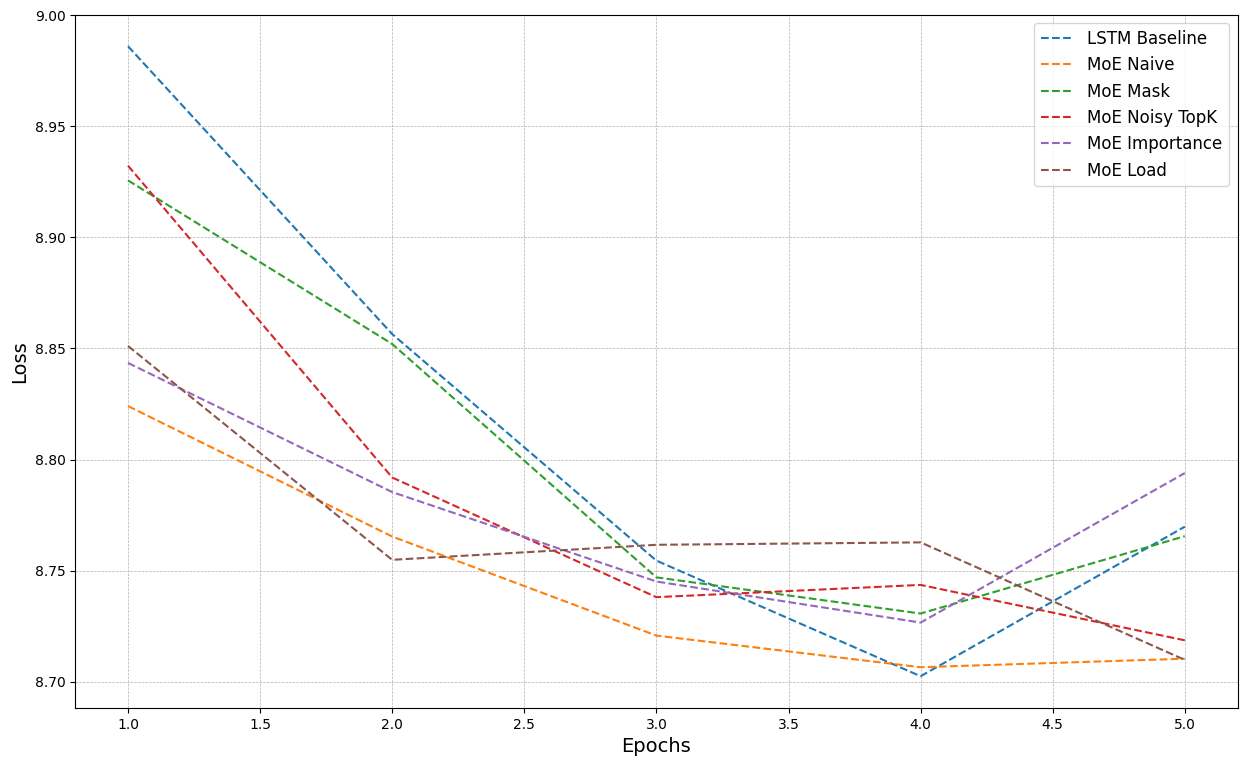

In [46]:
value = 'val_loss'
plt.figure(figsize=(15,9))
for trainer in trainers:
    epochs = range(1, len(trainers[trainer].history[value]) + 1)
    plt.plot(epochs, trainers[trainer].history[value],'--' ,label=f"{trainer}")

plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.show()

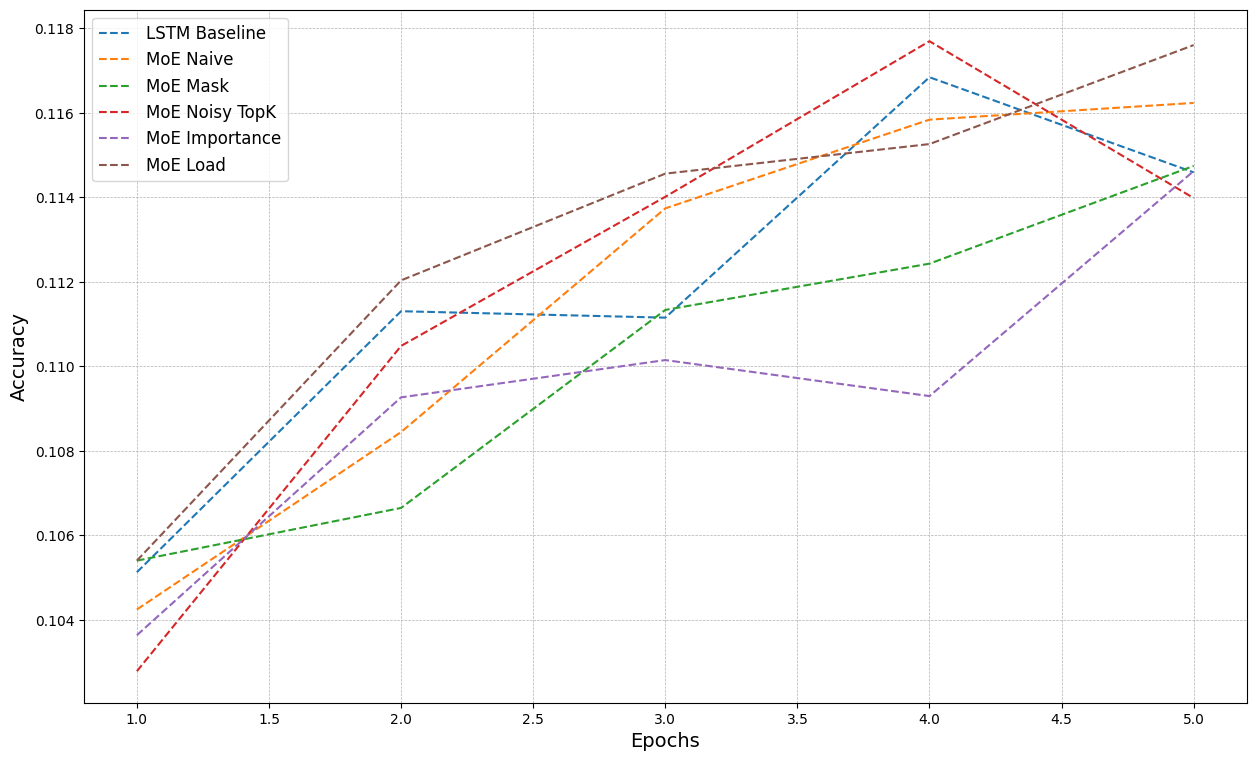

In [47]:
value = 'val_acc'
plt.figure(figsize=(15, 9))
for trainer in trainers:
    epochs = range(1, len(trainers[trainer].history[value]) + 1)
    plt.plot(epochs, trainers[trainer].history[value],'--' ,label=f"{trainer}")

plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.show()